In [ ]:
import findspark
findspark.init()
import pyspark
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

from pyspark import SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.linalg import Vectors

In [ ]:
import os
lehighId =  "tiq218" # Put here your Lehigh Id

config = pyspark.SparkConf().set('spark.executor.memory', '1024M')\
            .set('spark.cores.max', '10')\
            .set('spark.port.maxRetries','200')\
            .set('spark.ui.port', 4040 + hash(random.random())%200)\
            .set('spark.master', 'spark://polyp1:7077')\
            .set('spark.app.name', lehighId+" Project #3")

ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()
sc = ss.sparkContext

## <center> <font color=brown> Own Work Declaration </font> </center>


### <font color=blue> "We declare that all work submitted for final evaluation in this project is our own work and does not involve pla- giarism or collaboration outside of our own team. We also declare that we have not discussed the problems and/or solutions with anyone." </font>

## <center> <font color=brown> Predict the movement of stock price by sentimental analysis——A quantitative trading strategy (Team 10) </font> </center>

This project will be a testing demo for our own quantitative trading strategy. If it succeeds,
hopefully we can find a potential investor of our trading strategy:). 

Data is located in the `/scratch/ISE495/2020_project_03/team-10` folder. These are the files available to you.
1.   `/scratch/ISE495/2020_project_03/team-10/TSLA.csv` containing historical stock price data of Tesla
2.   `/scratch/ISE495/2020_project_03/team-10/tesla_analysis.csv` containing Micro-economic or operational analysis written by professions about tesla 
3.   `/scratch/ISE495/2020_project_03/team-10/News_Category_Dataset_v2.json` around 200k news headlines from the
year **2012** to **2018** obtained from HuffPost



<font color=DarkBlue> The main idea of our strategy is we firmly believe that daily news will definitely affect the
thinking of stockholders of a certain stock (for example, we will focus on Tesla in this project).
Analyzing the sentiment conveyed by every news would help us to predict the attitude of market
towards a stock. 

In [ ]:
# File paths
TeslaDataPath = "/scratch/ISE495/2020_project_03/team-10/TSLA.csv"
Tesla_analysisDataPath = "/scratch/ISE495/2020_project_03/team-10/tesla_analysis.csv"
NewsDataPath = "/scratch/ISE495/2020_project_03/team-10/News_Category_Dataset_v2.json"


# <font color=brown> Task 1 [10 pts.]: Getting Familiar with the Data </font>

Basic info such as # of news in each category ,
plot of tesla historical price, # of analysis about tesla in 2018,clean analysis of tesla

In [ ]:
# Task 1 code here



In [ ]:
price_tesla = sc.textFile(TeslaDataPath)

analysis_tesla = sc.textFile(Tesla_analysisDataPath)

news_data = sc.textFile(NewsDataPath)





In [ ]:
! head "/scratch/ISE495/2020_project_03/team-10/TSLA.csv"

In [ ]:
! head "/scratch/ISE495/2020_project_03/team-10/tesla_analysis.csv"

In [ ]:
! head "/scratch/ISE495/2020_project_03/team-10/News_Category_Dataset_v2.json"

### 1. # of news in each category 

In [ ]:

news_df=ss.read.json(NewsDataPath)
#news_df.show()

In [ ]:
#for simplicity, we only keep category of ['entertaiment','business','politics','sport','tech','science']
from pyspark.sql import functions as f
main_cat=['ENTERTAINMENT','BUSINESS','SPORTS','SCIENCE','TECH','POLITICS']
news_df=news_df.filter(f.col('category').isin(main_cat))

#and we will combine the "tech" and science to make our training set more balanced.
news_df=news_df.withColumn('category',f.when(f.col('category')=='SCIENCE','TECH').otherwise(f.col('category')))

In [ ]:
news_df.groupby('category').count().sort(f.col('count').desc()).show() #whole data set we will utilize

+-------------+-----+
|     category|count|
+-------------+-----+
|     POLITICS|32739|
|ENTERTAINMENT|16058|
|     BUSINESS| 5937|
|       SPORTS| 4884|
|         TECH| 4260|
+-------------+-----+



In [ ]:
#we make all news after 2018-01-01 as test data set
#all news before 2018-01-01 are training data set for classification
news_df_test=news_df.where(f.col('date')>='2018-01-01')
news_df_train=news_df.where(f.col('date')<'2018-01-01')

In [ ]:
news_df_train.show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|Rep. Jan Schakows...|     POLITICS|2017-12-31|Lessons From This...|https://www.huffi...|Imagine how many ...|
|Marjorie Cohn, Co...|     POLITICS|2017-12-31|Trump's "America ...|https://www.huffi...|The president's a...|
|Cody Lyon, Contri...|     POLITICS|2017-12-31|Non-Sanctuary Sta...|https://www.huffi...|The nation's most...|
|      Mary Papenfuss|ENTERTAINMENT|2017-12-31|Catelynn Lowell O...|https://www.huffi...|"So excited for t...|
|      Mary Papenfuss|     POLITICS|2017-12-31|Trump Booster Dav...|https://www.huffi...|The former sherif...|
|      Mary Papenfuss|         TECH|2017-12-31|New Year Kicks Of...|https://www.huffi...|2018's biggest su...|
|

In [ ]:
#Histogram of category in training set
news_df_train_hist=news_df_train.select("category").rdd.flatMap(lambda x: x)

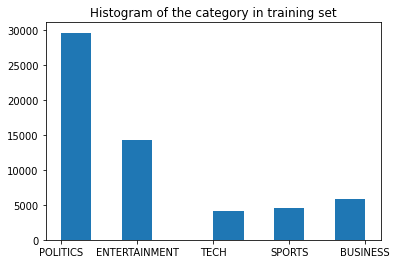

In [ ]:
plt.hist(news_df_train_hist.collect())
plt.title("Histogram of the category in training set")

plt.show()

# 1.1 # of news in each category (in training set and testing set)

In [ ]:
news_df_train.groupby('category').count().sort(f.col('count').desc()).show() #training set

+-------------+-----+
|     category|count|
+-------------+-----+
|     POLITICS|29672|
|ENTERTAINMENT|14338|
|     BUSINESS| 5851|
|       SPORTS| 4520|
|         TECH| 4165|
+-------------+-----+



In [ ]:
news_df_test.groupby('category').count().sort(f.col('count').desc()).show() #testing set

+-------------+-----+
|     category|count|
+-------------+-----+
|     POLITICS| 3067|
|ENTERTAINMENT| 1720|
|       SPORTS|  364|
|         TECH|   95|
|     BUSINESS|   86|
+-------------+-----+



### 2. Plot of tesla historical price


In [ ]:
price_tesla=ss.read.option("header",True).csv(TeslaDataPath)
price_tesla.show(10)

+---------+---------+---------+---------+---------+---------+--------+
|     Date|     Open|     High|      Low|    Close|Adj Close|  Volume|
+---------+---------+---------+---------+---------+---------+--------+
|6/29/2010|       19|       25|17.540001|23.889999|23.889999|18766300|
|6/30/2010|25.790001|    30.42|23.299999|    23.83|    23.83|17187100|
| 7/1/2010|       25|    25.92|    20.27|21.959999|21.959999| 8218800|
| 7/2/2010|       23|     23.1|18.709999|19.200001|19.200001| 5139800|
| 7/6/2010|       20|       20|    15.83|16.110001|16.110001| 6866900|
| 7/7/2010|     16.4|16.629999|    14.98|     15.8|     15.8| 6921700|
| 7/8/2010|16.139999|    17.52|    15.57|17.459999|17.459999| 7711400|
| 7/9/2010|    17.58|     17.9|16.549999|     17.4|     17.4| 4050600|
|7/12/2010|17.950001|    18.07|       17|17.049999|17.049999| 2202500|
|7/13/2010|17.389999|18.639999|     16.9|18.139999|18.139999| 2680100|
+---------+---------+---------+---------+---------+---------+--------+
only s

In [ ]:
price_tesla.describe()

DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [ ]:
#we will mainly focus on the adjusted price
#plot 
#change data type first
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DecimalType
from pyspark.sql.types import DateType
from datetime import datetime
from pyspark.sql.functions import col, udf
price_tesla = price_tesla.withColumn("Open", price_tesla["Open"].cast(DecimalType(8,4)))\
                         .withColumn("High", price_tesla["High"].cast(DecimalType(8,4)))\
                         .withColumn("Low", price_tesla["Low"].cast(DecimalType(8,4)))\
                         .withColumn("Close", price_tesla["Close"].cast(DecimalType(8,4)))\
                         .withColumn("Adj Close", price_tesla["Adj Close"].cast(DecimalType(8,4)))\
                         .withColumn("Volume", price_tesla["Volume"].cast(IntegerType()))\

#turn Date into datetype for plotting time series of historical price.
# This function converts the string cell into a date:
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

price_tesla = price_tesla.withColumn('Date', func(f.col('Date')))


In [ ]:
price_tesla.show()

+----------+-------+-------+-------+-------+---------+--------+
|      Date|   Open|   High|    Low|  Close|Adj Close|  Volume|
+----------+-------+-------+-------+-------+---------+--------+
|2010-06-29|19.0000|25.0000|17.5400|23.8900|  23.8900|18766300|
|2010-06-30|25.7900|30.4200|23.3000|23.8300|  23.8300|17187100|
|2010-07-01|25.0000|25.9200|20.2700|21.9600|  21.9600| 8218800|
|2010-07-02|23.0000|23.1000|18.7100|19.2000|  19.2000| 5139800|
|2010-07-06|20.0000|20.0000|15.8300|16.1100|  16.1100| 6866900|
|2010-07-07|16.4000|16.6300|14.9800|15.8000|  15.8000| 6921700|
|2010-07-08|16.1400|17.5200|15.5700|17.4600|  17.4600| 7711400|
|2010-07-09|17.5800|17.9000|16.5500|17.4000|  17.4000| 4050600|
|2010-07-12|17.9500|18.0700|17.0000|17.0500|  17.0500| 2202500|
|2010-07-13|17.3900|18.6400|16.9000|18.1400|  18.1400| 2680100|
|2010-07-14|17.9400|20.1500|17.7600|19.8400|  19.8400| 4195200|
|2010-07-15|19.9400|21.5000|19.0000|19.8900|  19.8900| 3739800|
|2010-07-16|20.7000|21.3000|20.0500|20.6

<AxesSubplot:xlabel='Date'>

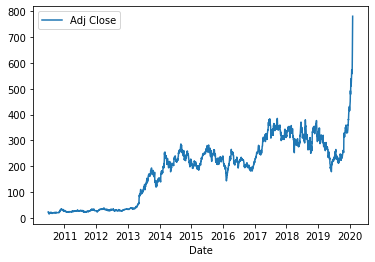

In [ ]:
#Plot 

time_series_price=price_tesla.select('Date','Adj Close').toPandas() 
time_series_price['Adj Close']=pd.to_numeric(time_series_price['Adj Close'])
           
time_series_price.plot(x='Date',y='Adj Close')

### 3. Clean the stock analysis data of tesla

In [ ]:
# store analysis of tesla in pandas dataframe

analysis_tesla_df=pd.read_csv(Tesla_analysisDataPath,encoding='windows-1250',header=None)
analysis_tesla_df.columns=['Title','Date']
#analysis_tesla_df

In [ ]:
analysis_tesla_df

,Title,Date
0,"Tesla: Nothing Matters, Until Everything Matters","Montana Skeptic•Yesterday, 1:56 PM•600 Comments"
1,Tesla: The Hype Does Not Reflect Reality,"The European View•Fri, Dec. 6•742 Comments"
2,Tesla Will Likely Achieve Record Deliveries In...,"iBEV•Wed, Dec. 4•340 Comments"
3,Tesla: Automatic Labeling For Computer Vision,"Trent Eady•Tue, Dec. 3•240 Comments"
4,Tesla: Ready To Re-Enter The Fast Lane,"DoctoRx•Tue, Dec. 3•229 Comments"
...,...,...
1150,Will GM Beat Tesla To Market For An Electric P...,"Anton Wahlman•Jan. 15, 2018•460 Comments"
1151,"Energy Storage Can Drive Future Tesla Growth, ...","Nick Cox•Jan. 15, 2018•466 Comments"
1152,Tesla: Cash Is King,"ValueAnalyst•Jan. 15, 2018•738 Comments"
1153,Tesla Bears Hang On,"ValueAnalyst•Jan. 11, 2018•483 Comments"


In [ ]:
#Clear data
from datetime import datetime
import re

###Consulted from https://algotrading101.com/learn/sentiment-analysis-python-guide/

newDateList = [] # create a list to store the cleaned dates
analysis_tesla_df['Date'][0]='Dec. 9'
for dateOfArticles in analysis_tesla_df['Date']: # loop every row in the "Date" column
    match = re.search(r'\w{3}\.\s\d{1,2}\,\s\d{4}|May\s\d{1,2}\,\s\d{4}|\w{3}\.\s\d{1,2}|May\s\d{1,2}', 
                      dateOfArticles)

    if re.search(r'\w{3}\.\s\d{1,2}\,\s\d{4}|\w{3}\s\d{1,2}\,\s\d{4}',match[0]):
        fulldate = match[0] # don't append year to string
    else:
        fulldate = match[0] + ", 2019" # append year to string
    
    for fmt in ('%b. %d, %Y', '%b %d, %Y'):
        try:
            newDate = datetime.strptime(fulldate, fmt).date()
            break # if format is correct, don't test any other formats
        except ValueError:
            pass
        
    newDateList.append(newDate) # add new date to the list

if len(newDateList) != analysis_tesla_df.shape[0]:
    print("Error: Rows don't match")
else:
    analysis_tesla_df['New Date'] = newDateList # add the list to our original dataframe

analysis_tesla_df

,Title,Date,New Date
0,"Tesla: Nothing Matters, Until Everything Matters",Dec. 9,2019-12-09
1,Tesla: The Hype Does Not Reflect Reality,"The European View•Fri, Dec. 6•742 Comments",2019-12-06
2,Tesla Will Likely Achieve Record Deliveries In...,"iBEV•Wed, Dec. 4•340 Comments",2019-12-04
3,Tesla: Automatic Labeling For Computer Vision,"Trent Eady•Tue, Dec. 3•240 Comments",2019-12-03
4,Tesla: Ready To Re-Enter The Fast Lane,"DoctoRx•Tue, Dec. 3•229 Comments",2019-12-03
...,...,...,...
1150,Will GM Beat Tesla To Market For An Electric P...,"Anton Wahlman•Jan. 15, 2018•460 Comments",2018-01-15
1151,"Energy Storage Can Drive Future Tesla Growth, ...","Nick Cox•Jan. 15, 2018•466 Comments",2018-01-15
1152,Tesla: Cash Is King,"ValueAnalyst•Jan. 15, 2018•738 Comments",2018-01-15
1153,Tesla Bears Hang On,"ValueAnalyst•Jan. 11, 2018•483 Comments",2018-01-11


In [ ]:
#We only need news in 2018 for training:
analysis_tesla_df=analysis_tesla_df[analysis_tesla_df['New Date']<datetime.strptime('2019-01-01', "%Y-%m-%d").date()]

In [ ]:
analysis_tesla_df.reset_index()

,index,Title,Date,New Date
0,403,The Tesla Growth Narrative Quietly Winds Down,"CoverDrive•Dec. 31, 2018•510 Comments",2018-12-31
1,404,Tesla: Demand Pull-Forward Risk,"Elazar Advisors, LLC•Dec. 31, 2018•153 Comments",2018-12-31
2,405,Tesla Offers To Forgive Your Lease Payments If...,"Anton Wahlman•Dec. 31, 2018•131 Comments",2018-12-31
3,406,Tesla Q4 2018 Delivery Preview,"Bill Maurer•Dec. 30, 2018•382 Comments",2018-12-30
4,407,Tesla Should Have No Problem Sustaining Demand,"Sean Chandler•Dec. 28, 2018•409 Comments",2018-12-28
...,...,...,...,...
747,1150,Will GM Beat Tesla To Market For An Electric P...,"Anton Wahlman•Jan. 15, 2018•460 Comments",2018-01-15
748,1151,"Energy Storage Can Drive Future Tesla Growth, ...","Nick Cox•Jan. 15, 2018•466 Comments",2018-01-15
749,1152,Tesla: Cash Is King,"ValueAnalyst•Jan. 15, 2018•738 Comments",2018-01-15
750,1153,Tesla Bears Hang On,"ValueAnalyst•Jan. 11, 2018•483 Comments",2018-01-11


In [ ]:

print("number of analysis of tesla in 2018:",analysis_tesla_df.shape[0])

number of analysis of tesla in 2018: 752


# <font color=brown> Task 2 [20 pts.]: Most correlated words </font>

Find most correlated words(top 5) in each category, this would be used as features in
further analysis


In [ ]:
# Task 2 code here

main_cat=['ENTERTAINMENT','BUSINESS','SPORTS','SCIENCE','TECH','POLITICS']

In [ ]:
# label each category
news_df_train=news_df_train.withColumn('category_id',f.when(f.col('category')=='ENTERTAINMENT',0)\
                                       .when(f.col('category')=='BUSINESS',1)\
                                       .when(f.col('category')=='SPORTS',2)\
                                       .when(f.col('category')=='POLITICS',3)\
                                       .otherwise(4))

In [ ]:
news_df_test=news_df_test.withColumn('category_id',f.when(f.col('category')=='ENTERTAINMENT',0)\
                                       .when(f.col('category')=='BUSINESS',1)\
                                       .when(f.col('category')=='SPORTS',2)\
                                       .when(f.col('category')=='POLITICS',3)\
                                       .otherwise(4))

In [ ]:
news_df_train.show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+-----------+
|             authors|     category|      date|            headline|                link|   short_description|category_id|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+-----------+
|Rep. Jan Schakows...|     POLITICS|2017-12-31|Lessons From This...|https://www.huffi...|Imagine how many ...|          3|
|Marjorie Cohn, Co...|     POLITICS|2017-12-31|Trump's "America ...|https://www.huffi...|The president's a...|          3|
|Cody Lyon, Contri...|     POLITICS|2017-12-31|Non-Sanctuary Sta...|https://www.huffi...|The nation's most...|          3|
|      Mary Papenfuss|ENTERTAINMENT|2017-12-31|Catelynn Lowell O...|https://www.huffi...|"So excited for t...|          0|
|      Mary Papenfuss|     POLITICS|2017-12-31|Trump Booster Dav...|https://www.huffi...|The former sherif...|          3|
|      Mary Pape

In [ ]:
#For reference
category_to_id={'ENTERTAINMENT': 0, 'BUSINESS': 1, 'SPORTS': 2, 'POLITICS': 3,'TECH': 4}
id_to_category={0: 'ENTERTAINMENT', 1: 'BUSINESS', 2: 'SPORTS', 3: 'POLITICS', 4:'TECH'}

In [ ]:
#Combine column  headline and short description together to form our "feature text"
#from pyspark.sql import functions as sf
news_df_train = news_df_train.withColumn('Text', 
                    f.concat(f.col('headline'),f.lit(' '), f.col('short_description')))
#news_df_train.show()

#Then we only keep category_id and text
news_df_train=news_df_train.select('category_id','Text')

In [ ]:
news_df_train.show()

+-----------+--------------------+
|category_id|                Text|
+-----------+--------------------+
|          3|Lessons From This...|
|          3|Trump's "America ...|
|          3|Non-Sanctuary Sta...|
|          0|Catelynn Lowell O...|
|          3|Trump Booster Dav...|
|          4|New Year Kicks Of...|
|          3|Donald Trump Heat...|
|          3|Top GOP Races To ...|
|          2|Cleveland Browns ...|
|          0|Chelsea Clinton G...|
|          1|Minimum Wage Rais...|
|          0|That 'Last Jedi' ...|
|          0|Annette Bening On...|
|          3|Trump Justice Dep...|
|          3|George Papadopoul...|
|          4|2017 Was The Year...|
|          3|Marco Rubio: Tax ...|
|          3|Judge Denies Rick...|
|          3|Rick Gates Files ...|
|          3|Trump Again Threa...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
# #Combine column  headline and short description together to form our "feature text" (Same thing for testing data)
# #from pyspark.sql import functions as sf
# news_df_test = news_df_test.withColumn('Text', 
#                     f.concat(f.col('headline'),f.lit(' '), f.col('short_description')))
# #news_df_train.show()

# #Then we only keep category_id and text
# news_df_test=news_df_test.select('category_id','Text')

In [ ]:
%pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... - done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Convert words in the news short description into numerical features using tfdif

###Consulted from https://www.kaggle.com/bbose71/bbc-news-classification
from sklearn.feature_extraction.text import TfidfVectorizer
news_df_train_pd =news_df_train.toPandas()

#news_df_train_pd['text'] = news_df_train.headline + " " + news_df_train.short_description
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english',
                        max_features=100)  #Choose 100 features

features = tfidf.fit_transform(news_df_train_pd.Text).toarray() # Remaps the words in the 58546 news in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

features.shape                          # represents features identified by tfidf

(58546, 100)

In [ ]:
category_to_id.items()
labels = np.array(news_df_train.select('category_id').collect())

In [ ]:
# Use chi-square analysis to find corelation between features (importance of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 5  # We are going to look for top 5 freq words

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [word for word in feature_names if len(word.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [word for word in feature_names if len(word.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'BUSINESS':
  . Most correlated unigrams:
       . donald
       . women
       . trump
       . work
       . business
  . Most correlated bigrams:
       . bernie sanders
       . supreme court
       . white house
       . hillary clinton
       . donald trump
# 'ENTERTAINMENT':
  . Most correlated unigrams:
       . gop
       . love
       . trump
       . star
       . film
  . Most correlated bigrams:
       . white house
       . bernie sanders
       . supreme court
       . hillary clinton
       . donald trump
# 'POLITICS':
  . Most correlated unigrams:
       . clinton
       . obama
       . donald
       . gop
       . trump
  . Most correlated bigrams:
       . bernie sanders
       . white house
       . supreme court
       . hillary clinton
       . donald trump
# 'SPORTS':
  . Most correlated unigrams:
       . world
       . trump
       . video
       . win
       . game
  . Most correlated bigrams:
       . bernie sanders
       . supreme court
       . white ho

# <font color=brown> Task 3 [20 pts.]: Visualizing high dimensional classification

Try t-SNE  and PCA to reduce dimension of features in 2 and do some interesting plot of projected
components.

t-Distributed Stochastc neighbor Embedding : Keeps similar instances close and dissimilar instances apart


In [ ]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.08)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 



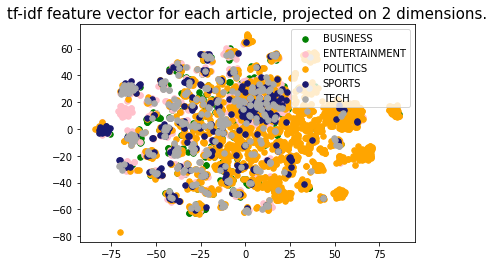

In [ ]:
 
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [ ]:
#PCR


data=pd.DataFrame(features[indices], columns = [i for i in range(len(features[0]))])
dataset=ss.createDataFrame(data,[str(i) for i in range(len(features[0]))] )

In [ ]:
dataset.show(20)

+---+-----------------+-------------------+---+---+------------------+---+------------------+---+---+---+------------------+---+---+---+---+---+---+---+-----------------+------------------+------------------+------------------+---+---+------------------+---+---+---+---+---+---+---+------------------+------------------+-------------------+---+-------------------+---+-------------------+---+---+------------------+---+---+---+---+------------------+---+---+---+-------------------+---+---+---+---+---+---+------------------+------------------+---+---+---+---+---+------------------+---+---+---+---+---+---+---+---+---+---+---+---+------------------+------------------+-------------------+---+---+------------------+------------------+---+---+---+---+-------------------+---+---+---+---+---+-------------------+------------------+---+---+---+
|  0|                1|                  2|  3|  4|                 5|  6|                 7|  8|  9| 10|                11| 12| 13| 14| 15| 16| 17| 18|     

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
assembler = VectorAssembler(
    inputCols = [str(i) for i in range(len(features[0]))], outputCol = 'features')

# use it to transform the dataset and select just
# the output column
df = assembler.transform(dataset).select('features')
df.show(10)

+--------------------+
|            features|
+--------------------+
|    (100,[92],[1.0])|
|(100,[11,33,34],[...|
|         (100,[],[])|
|         (100,[],[])|
|         (100,[],[])|
|(100,[20,39,78,84...|
|(100,[7,19,47],[0...|
|(100,[1,2,89],[0....|
|(100,[51,96],[0.4...|
|(100,[51,58,59],[...|
+--------------------+
only showing top 10 rows



In [ ]:
n_components = 2  #two dimension
pca = PCA(
    k = n_components, 
    inputCol = 'features', 
    outputCol = 'pcaFeatures'
).fit(df)

plant_pca = pca.transform(df)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
plant_pca.show(6)

Explained Variance Ratio [0.05111899 0.03606067]
+--------------------+--------------------+
|            features|         pcaFeatures|
+--------------------+--------------------+
|    (100,[92],[1.0])|[0.00402591871195...|
|(100,[11,33,34],[...|[-0.0446953325605...|
|         (100,[],[])|           [0.0,0.0]|
|         (100,[],[])|           [0.0,0.0]|
|         (100,[],[])|           [0.0,0.0]|
|(100,[20,39,78,84...|[0.01964301582893...|
+--------------------+--------------------+
only showing top 6 rows



In [ ]:
X_pca = plant_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [ ]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional plant data"""
    markers = 's', 'x', 'o',"+","*"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label =id_to_category[t], marker = m)

    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()

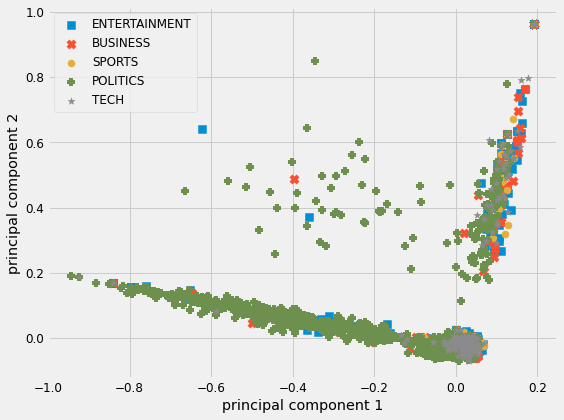

In [ ]:
y= labels[indices]

plot_iris_pca(X_pca, y)

# <font color=brown> Task 4 [30 pts.]: Classification </font>

Try different models and do some tunings of parameters on training set and
validation set then select the best one for prediction on test set, we can also do some
performance analysis such as confusion matrix)

But notice that in task 1, we see our new_train_df ia a seriously imbalanced dataset which will make our model overfitting. Therefore we decide to focus on politics and non-politics news. 


In [ ]:
#Relabeling news:
def politics(s):
  category=s[0]
  if category==3:
    label=1
  else:
    label=0
  return(label,s[1])

news_df_train_politics=news_df_train.withColumn('label',f.when(f.col('category_id')==3,1).otherwise(0))


In [ ]:
news_df_train_politics=news_df_train_politics.select('label','Text')

In [ ]:
news_df_train_politics.show()

+-----+--------------------+
|label|                Text|
+-----+--------------------+
|    1|Lessons From This...|
|    1|Trump's "America ...|
|    1|Non-Sanctuary Sta...|
|    0|Catelynn Lowell O...|
|    1|Trump Booster Dav...|
|    0|New Year Kicks Of...|
|    1|Donald Trump Heat...|
|    1|Top GOP Races To ...|
|    0|Cleveland Browns ...|
|    0|Chelsea Clinton G...|
|    0|Minimum Wage Rais...|
|    0|That 'Last Jedi' ...|
|    0|Annette Bening On...|
|    1|Trump Justice Dep...|
|    1|George Papadopoul...|
|    0|2017 Was The Year...|
|    1|Marco Rubio: Tax ...|
|    1|Judge Denies Rick...|
|    1|Rick Gates Files ...|
|    1|Trump Again Threa...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
#news_rdd_train_2=news_rdd_train.toDF('label','Text')
#training, validation, testing
training, validation = news_df_train_politics.randomSplit( [ 0.7 , 0.3 ] , seed = 217)

# Logistic regression

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

###Consulted from https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [1000]) \
    .addGrid(lr.regParam, [1,0.1, 0.01,0.001]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training.toDF('label','Text'))

In [ ]:
param_dict_lr=cvModel.bestModel.stages[-1].extractParamMap()
#param_dict_hash=cvModel.bestModel.stages[-2].extractParamMap()
lr_dict = {}
for k, v in param_dict_lr.items():
  lr_dict[k.name] = v

# token_dict = {}
# for k, v in param_dict_hash.items():
#   token_dict[k.name] = v

best_reg = lr_dict["regParam"]
#best_num_features = token_dict["numFeatures"]

print("Best regParam is:",best_reg)


Best regParam is: 0.1


In [ ]:

n_validation=validation.count()
prediction_lr = cvModel.transform(validation)
num_errors=prediction_lr.where(prediction_lr["label"]!=prediction_lr["prediction"]).count()
error=num_errors/n_validation

print("validation accuracy:",1-error)

validation accuracy: 0.7976421004670236


# Decision tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
###Consulted from https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
dt = DecisionTreeClassifier()

pipeline = Pipeline(stages=[tokenizer, hashingTF, dt])


paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [1000]) \
    .addGrid(dt.impurity, ['gini','entropy']) \
    .addGrid(dt.maxDepth, [5,10,20]) \
    .addGrid(dt.maxBins, [10,20,32]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel_dt = crossval.fit(training.toDF('label','Text'))

In [ ]:
param_dict_dt=cvModel_dt.bestModel.stages[-1].extractParamMap()
#param_dict_hash_dt=cvModel_dt.bestModel.stages[-2].extractParamMap()
dt_dict = {}
for k, v in param_dict_dt.items():
  dt_dict[k.name] = v

# token_dict = {}
# for k, v in param_dict_hash_dt.items():
#   token_dict[k.name] = v

best_impurity = dt_dict["impurity"]
best_maxDepth = dt_dict["maxDepth"]
best_maxBins = dt_dict["maxBins"]
#best_num_features = token_dict["numFeatures"]


print("Best regParam is:",best_impurity)
print("Best maxDepth is:",best_maxDepth)
print("Best maxBins is:",best_maxBins)
#print("Bset n_features in HashingTF is:",best_num_features)

Best regParam is: gini
Best maxDepth is: 5
Best maxBins is: 10


In [ ]:
n_validation=validation.count()
prediction_dt = cvModel_dt.transform(validation)
num_errors=prediction_dt.where(prediction_dt["label"]!=prediction_dt["prediction"]).count()
error=num_errors/n_validation

print("validation accuracy:",1-error)

validation accuracy: 0.6605535938033944


# SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
###Consulted from https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lsvc = LinearSVC(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lsvc])


paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [1000]) \
    .addGrid(lsvc.regParam, [100,10,1,0.1, 0.01,0.001]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 5 folds 

# Run cross-validation, and choose the best set of parameters.
cvModel_svm = crossval.fit(training.toDF('label','Text'))

In [ ]:
param_dict_svm=cvModel_svm.bestModel.stages[-1].extractParamMap()
#param_dict_hash_dt=cvModel_dt.bestModel.stages[-2].extractParamMap()
svm_dict = {}
for k, v in param_dict_svm.items():
  svm_dict[k.name] = v

# token_dict = {}
# for k, v in param_dict_hash_dt.items():
#   token_dict[k.name] = v

best_regParam = svm_dict["regParam"]
#best_num_features = token_dict["numFeatures"]


print("Best regParam is:",best_regParam)
#print("Bset n_features in HashingTF is:",best_num_features)

Best regParam is: 0.01


In [ ]:
n_validation=validation.count()
prediction_svm = cvModel_svm.transform(validation)
num_errors=prediction_svm.where(prediction_svm["label"]!=prediction_svm["prediction"]).count()
error=num_errors/n_validation

print("validation accuracy:",1-error)

validation accuracy: 0.7963891103770361


# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
rc = RandomForestClassifier()
pipeline = Pipeline(stages=[tokenizer, hashingTF, rc])


paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [1000]) \
    .addGrid(rc.impurity, ['gini','entropy']) \
    .addGrid(rc.maxDepth, [5,10,20]) \
    .addGrid(rc.maxBins, [10,20,32]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel_rc = crossval.fit(training.toDF('label','Text'))

In [ ]:
param_dict_rc=cvModel_rc.bestModel.stages[-1].extractParamMap()
#param_dict_hash_dt=cvModel_dt.bestModel.stages[-2].extractParamMap()
rc_dict = {}
for k, v in param_dict_rc.items():
  rc_dict[k.name] = v

# token_dict = {}
# for k, v in param_dict_hash_dt.items():
#   token_dict[k.name] = v

best_impurity = rc_dict["impurity"]
best_maxDepth = rc_dict["maxDepth"]
best_maxBins = rc_dict["maxBins"]
#best_num_features = token_dict["numFeatures"]


print("Best impurity is:",best_impurity)
print("Best maxDepth is:",best_maxDepth)
print("Best maxBins is:",best_maxBins)
#print("Bset n_features in HashingTF is:",best_num_features)

Best impurity is: entropy
Best maxDepth is: 20
Best maxBins is: 10


In [ ]:
n_validation=validation.count()
prediction_rf = cvModel_rc.transform(validation)
num_errors=prediction_rf.where(prediction_rf["label"]!=prediction_rf["prediction"]).count()
error=num_errors/n_validation

print("validation accuracy:",1-error)

validation accuracy: 0.746497323157535


In [ ]:
#Plot roc for each model
from sklearn.metrics import roc_curve
#Logistric regression
preds_lr = prediction_lr.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
y_score_lr, y_true_lr = zip(*preds_lr)
fpr1, tpr1, thresholds1 = roc_curve(y_true_lr, y_score_lr, pos_label = 1)

#Decision tree
preds_dt = prediction_dt.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
y_score_dt, y_true_dt = zip(*preds_dt)
fpr2, tpr2, thresholds2 = roc_curve(y_true_dt, y_score_dt, pos_label = 1)

#SVM
preds_svm = prediction_svm.select('label','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['label']))).collect()
y_score_svm, y_true_svm = zip(*preds_svm)
fpr3, tpr3, thresholds3 = roc_curve(y_true_svm, y_score_svm, pos_label = 1)

#Random forest
preds_rf = prediction_rf.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
y_score_rf, y_true_rf = zip(*preds_rf)
fpr4, tpr4, thresholds4 = roc_curve(y_true_rf, y_score_rf, pos_label = 1)

# #Naive Bayes
# preds_nb = prediction_nb.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
# y_score_nb, y_true_nb = zip(*preds_nb)
# fpr5, tpr5, thresholds5 = roc_curve(y_true_nb, y_score_nb, pos_label = 1)

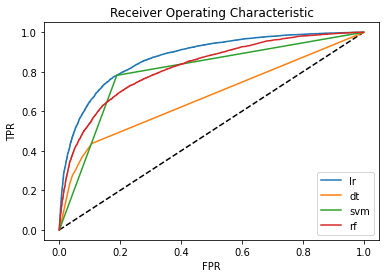

In [ ]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "lr")
plt.plot(fpr2, tpr2, label= "dt")
plt.plot(fpr3, tpr3, label= "svm")
plt.plot(fpr4, tpr4, label= "rf")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(prediction_lr.select('label').rdd.collect(),prediction_lr.select('prediction').rdd.collect())

array([[7126, 1548],
       [2005, 6879]])

# Conclusion for task 4:

Comparing logistic regression, decision tree, support vector machine and random forest model, we found that the performance of logistic regression is better based on ROC curve. Although the accuracy is not too high, we at least filtered worse options. Therefore, we will utilize logistic regression as the model to classify our news. (Probably we could apply multi-class logistic regression in future development.

# Extension for task 4: Multiclass classification 

# 4.5 Multiclass 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

###Consulted from https://www.kaggle.com/bbose71/bbc-news-classification

models = [
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0,criterion='entropy'),
    MultinomialNB(),
    LogisticRegression(random_state=0,C=0.1),
]

CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [ ]:
#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)  #feature has dimention=100
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

/home/mmd/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mmd/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mmd/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/mmd/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vec

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

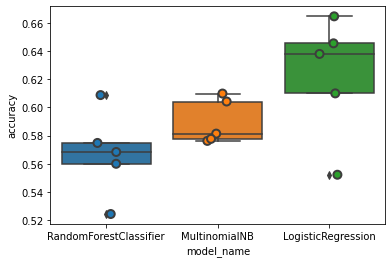

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# Task 5
We will first futher tune logistic regression model based on politics news and then classify macro news in our testing set. Finally we will do sentimental analysis of macro news and micro
analysis

In [ ]:
training.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|20788|
|    0|20200|
+-----+-----+



## 5.1 Further tuning on logistic regression

In [ ]:
#Pipeline cross validation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=20)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
  #try more features

paramGrid = ParamGridBuilder().addGrid(hashingTF.numFeatures, [2000]).addGrid(lr.regParam, [10,1,0.1,0.01,0.001,0.0001]) \
    .addGrid(lr.elasticNetParam, [1,0.9,0.8,0.7,0.5,0.4,0.3,0.2,0.1,0]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel_tuned = crossval.fit(training.toDF('label','Text'))


In [ ]:
param_dict_lr=cvModel_tuned.bestModel.stages[-1].extractParamMap()
#param_dict_hash=cvModel.bestModel.stages[-2].extractParamMap()
lr_dict = {}
for k, v in param_dict_lr.items():
  lr_dict[k.name] = v

# token_dict = {}
# for k, v in param_dict_hash.items():
#   token_dict[k.name] = v

best_reg = lr_dict["regParam"]
best_elasticNetParam = lr_dict["elasticNetParam"]
#best_num_features = token_dict["numFeatures"]

print("Best regParam is:",best_reg)
print("Best elasticNetParam is:",best_elasticNetParam)

Best regParam is: 0.1
Best elasticNetParam is: 0.0


In [ ]:

n_validation=validation.count()
prediction_lr = cvModel_tuned.transform(validation)
num_errors=prediction_lr.where(prediction_lr["label"]!=prediction_lr["prediction"]).count()
error=num_errors/n_validation

print("validation accuracy:",1-error)

validation accuracy: 0.8292516231917075


# 5.1.2 Classify politic news for further sentimental analysis.

In [ ]:
#Preprocess news testing data

news_df_test_politics=news_df_test.withColumn('label',f.when(f.col('category_id')==3,1).otherwise(0))

news_df_test_politics = news_df_test_politics.withColumn('Text', 
                    f.concat(f.col('headline'),f.lit(' '), f.col('short_description')))
news_df_test_politics=news_df_test_politics.select('label','date','Text')

#news_df_test_politics.show(10)


#Prediction on testing set

prediction_lr_tesing = cvModel_tuned.transform(news_df_test_politics)

In [ ]:
prediction_lr_tesing.show(10)

+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|      date|                Text|               words|            features|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    0|2018-05-26|Will Smith Joins ...|[will, smith, joi...|(2000,[17,66,153,...|[1.39573126367795...|[0.80150563068859...|       0.0|
|    0|2018-05-26|Hugh Grant Marrie...|[hugh, grant, mar...|(2000,[17,84,157,...|[1.93452525350294...|[0.87374945154517...|       0.0|
|    0|2018-05-26|Jim Carrey Blasts...|[jim, carrey, bla...|(2000,[17,106,223...|[-1.9263559763556...|[0.12715446729955...|       1.0|
|    0|2018-05-26|Julianna Margulie...|[julianna, margul...|(2000,[1,17,320,3...|[-0.8581465088547...|[0.29772673848040...|       1.0|
|    0|2018-05-26|Morgan Freeman 'D...|[morgan, freeman

In [ ]:

n_testing=news_df_test_politics.count()
#prediction_lr = cvModel.transform(validation)
num_errors=prediction_lr_tesing.where(prediction_lr_tesing["label"]!=prediction_lr_tesing["prediction"]).count()
error=num_errors/n_testing

print("Testing accuracy:",1-error)

Testing accuracy: 0.8405851462865717


### 5.2 Sentimental analysis for micro news w.r.t Tesla

In [ ]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Set up nltk library and download vader lexicon
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()



NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DecimalType


from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

results = []

for headline in analysis_tesla_df['Title']:
    pol_score = SIA().polarity_scores(headline) # run analysis
    pol_score['headline'] = headline # add headlines for viewing
    results.append(pol_score)

#results

In [ ]:
analysis_tesla_df['Score'] = pd.DataFrame(results)['compound'].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
pd.DataFrame(results)

,neg,neu,pos,compound,headline
0,0.000,0.698,0.302,0.3818,The Tesla Growth Narrative Quietly Winds Down
1,0.643,0.357,0.000,-0.3818,Tesla: Demand Pull-Forward Risk
2,0.000,0.861,0.139,0.2732,Tesla Offers To Forgive Your Lease Payments If...
3,0.000,1.000,0.000,0.0000,Tesla Q4 2018 Delivery Preview
4,0.615,0.385,0.000,-0.6597,Tesla Should Have No Problem Sustaining Demand
...,...,...,...,...,...
747,0.000,1.000,0.000,0.0000,Will GM Beat Tesla To Market For An Electric P...
748,0.000,0.630,0.370,0.5719,"Energy Storage Can Drive Future Tesla Growth, ..."
749,0.000,1.000,0.000,0.0000,Tesla: Cash Is King
750,0.000,1.000,0.000,0.0000,Tesla Bears Hang On


### 5.3 Sentimental analysis for macro news in 2018 (In politics environment

In [ ]:
# #Since we only care about politics news, we transfer other categories into 0 state.

# news_df_test_politics=news_df_test.withColumn('label',f.when(f.col('category_id')==3,1).otherwise(0))

# news_df_test_politics = news_df_test_politics.withColumn('Text', 
#                     f.concat(f.col('headline'),f.lit(' '), f.col('short_description')))
# news_df_test_politics=news_df_test_politics.select('label','date','text')

# news_df_test_politics.show(10)

+-----+----------+--------------------+
|label|      date|                text|
+-----+----------+--------------------+
|    0|2018-05-26|Will Smith Joins ...|
|    0|2018-05-26|Hugh Grant Marrie...|
|    0|2018-05-26|Jim Carrey Blasts...|
|    0|2018-05-26|Julianna Margulie...|
|    0|2018-05-26|Morgan Freeman 'D...|
|    0|2018-05-26|Donald Trump Is L...|
|    0|2018-05-26|What To Watch On ...|
|    0|2018-05-26|Mike Myers Reveal...|
|    0|2018-05-26|What To Watch On ...|
|    0|2018-05-26|Justin Timberlake...|
+-----+----------+--------------------+
only showing top 10 rows



In [ ]:
# spark udf can't utilize SIA function in nltk(i don't know why, probably due to some path problem.） thus we transer our spark dataframe into pandas dataframe.
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
news_df_test_politics_pd=prediction_lr_tesing.select('label','prediction','date','Text') .toPandas()

results_test = []

for headline in news_df_test_politics_pd['Text']:
    pol_score = SIA().polarity_scores(headline) # run analysis
    pol_score['headline'] = headline # add headlines for viewing
    results_test.append(pol_score)

news_df_test_politics_pd['Score'] = pd.DataFrame(results_test)['compound']

In [ ]:
news_df_test_politics_pd.head(20)

,label,prediction,date,Text,Score
0,0,0.0,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0.0000
1,0,0.0,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0.3612
2,0,1.0,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0.3412
3,0,1.0,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0.0000
4,0,1.0,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,-0.8591
5,0,0.0,2018-05-26,Donald Trump Is Lovin' New McDonald's Jingle I...,0.0000
6,0,0.0,2018-05-26,What To Watch On Amazon Prime That’s New This ...,0.7003
7,0,0.0,2018-05-26,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,0.3612
8,0,0.0,2018-05-26,What To Watch On Hulu That’s New This Week You...,0.0000
9,0,0.0,2018-05-26,Justin Timberlake Visits Texas School Shooting...,0.2500


# Task 6. 
(Open end) Try to figure out a robust way to calculate
comprehensive sentimental scores of tesla every day and then predict the movement of
stock price of tesla

# 6.1: Aggregate daily sentiment scores for micro and macro news

In [ ]:
#Step 1: Aggregate daily sentiment scores for micro and macro news

analysis_tesla_df_2 = analysis_tesla_df.groupby(['New Date']).sum()
news_df_test_politics_pd_2 = news_df_test_politics_pd.groupby(['date','prediction'])['Score'].sum()
news_df_test_politics_pd_2=news_df_test_politics_pd_2.reset_index()

In [ ]:
#We divide data of news into two sub dataframes: politic news and non-politic news
#Non-politics
news_df_test_politics_pd_2_nonP=news_df_test_politics_pd_2[news_df_test_politics_pd_2['prediction']==0]
news_df_test_politics_pd_2_nonP=news_df_test_politics_pd_2_nonP.reset_index()

#Politics
news_df_test_politics_pd_2_P=news_df_test_politics_pd_2[news_df_test_politics_pd_2['prediction']==1]
news_df_test_politics_pd_2_P=news_df_test_politics_pd_2_P.reset_index()

In [ ]:
#convert string to datatime
news_df_test_politics_pd_2_P['date']=pd.to_datetime(news_df_test_politics_pd_2_P['date'])
news_df_test_politics_pd_2_nonP['date']=pd.to_datetime(news_df_test_politics_pd_2_nonP['date'])

In [ ]:
news_df_test_politics_pd_2_P

RangeIndex(start=0, stop=146, step=1)

 # 6.2 Utilize tesla historical price data and calculate our returns.

In [ ]:
# now we will utilize tesla historical price data and calculate our returns.

time_series_price['LogPrice'] = np.log(time_series_price['Adj Close'])
#np.log(time_series_price['Adj Close']/time_series_price['Adj Close'].shift(1)) #- 1 # calculate daily returns

In [ ]:
#type(time_series_price['Date'][1])
# get historical data in 2018.
time_series_price_2018=time_series_price[(time_series_price['Date']<datetime.strptime('2019-01-01', "%Y-%m-%d").date())
                                         &(time_series_price['Date']>datetime.strptime('2017-12-31', "%Y-%m-%d").date()) ]
time_series_price_2018.head()                                         

,Date,Adj Close,LogPrice
1891,2018-01-02,320.53,5.769976
1892,2018-01-03,317.25,5.759690
1893,2018-01-04,314.62,5.751366
1894,2018-01-05,316.58,5.757576
1895,2018-01-08,336.41,5.818331


#  6.3: Check relationship between lagged score against returns (daily)

## 6.3.1  Relabel the sentiment score for politics and non-politics

In [ ]:
#Relabel the sentiment score for politics and non-politics

analysis_tesla_df_2['Score_micro'] = analysis_tesla_df_2['Score']#.shift(1)
news_df_test_politics_pd_2_nonP['Score_macro_nonP']=news_df_test_politics_pd_2_nonP['Score']#.shift(1)
news_df_test_politics_pd_2_P['Score_macro_P']=news_df_test_politics_pd_2_P['Score']#.shift(1)

In [ ]:
news_df_test_politics_pd_2_P

,index,date,prediction,Score,Score_macro_P
0,1,2018-01-01,1.0,-0.2641,-0.2641
1,3,2018-01-02,1.0,1.0280,1.0280
2,5,2018-01-03,1.0,-1.6370,-1.6370
3,7,2018-01-04,1.0,0.4734,0.4734
4,9,2018-01-05,1.0,-1.9516,-1.9516
...,...,...,...,...,...
141,283,2018-05-22,1.0,1.9785,1.9785
142,285,2018-05-23,1.0,-1.1585,-1.1585
143,287,2018-05-24,1.0,-6.0843,-6.0843
144,289,2018-05-25,1.0,-3.0550,-3.0550


## 6.3.2 Match the daily returns with sentiment score

In [ ]:
time_series_price_2018.shape[0]

251

In [ ]:
analysis_tesla_df_2.shape[0]

255

In [ ]:
news_df_test_politics_pd_2_P.shape[0],news_df_test_politics_pd_2_nonP.shape[0]

(146, 146)

Observation: The number of row of sentiment score dataframe is not the same as the number of rows of returns. Becasue not some trading days might not have news and our news data ends in 2018-05-26. Thus we need to match the daily returns against the corresponding sentiment scores before we can run the regression.

In [ ]:
analysis_tesla_df_2

,Score,Score_micro
New Date,,
2018-01-11,0.0000,0.0000
2018-01-15,0.5719,0.5719
2018-01-16,-0.1027,-0.1027
2018-01-17,-0.1280,-0.1280
2018-01-18,0.0000,0.0000
...,...,...
2018-12-26,0.0000,0.0000
2018-12-27,0.5106,0.5106
2018-12-28,-0.9997,-0.9997


In [ ]:
#Set index by data for each dataframe
from functools import reduce
time_series_price_2018=time_series_price_2018.set_index('Date')
time_series_price_2018=time_series_price_2018.rename_axis('date')
analysis_tesla_df_2=analysis_tesla_df_2.rename_axis('date')
news_df_test_politics_pd_2_P=news_df_test_politics_pd_2_P.set_index('date')
news_df_test_politics_pd_2_nonP=news_df_test_politics_pd_2_nonP.set_index('date')



#combineddata = pd.merge(time_series_price_2018[['Returns']], analysis_tesla_df_2[['Score(1)']], left_index=True, right_index=True, how='left')

In [ ]:
# Use reduce method to merge corresponding data
dfs=[time_series_price_2018[['LogPrice']],analysis_tesla_df_2[['Score_micro']],news_df_test_politics_pd_2_P[['Score_macro_P']],
     news_df_test_politics_pd_2_nonP[['Score_macro_nonP']]]
combineddata = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              left_index=True, right_index=True, 
                                              how='inner'), 
                  dfs)

In [ ]:
combineddata.head()

,LogPrice,Score_micro,Score_macro_P,Score_macro_nonP
date,,,,
2018-01-11,5.822898,0.0000,-4.7476,-0.5901
2018-01-16,5.829122,-0.1027,-1.2076,-1.5246
2018-01-17,5.849786,-0.1280,0.4535,-2.9267
2018-01-18,5.842297,0.0000,-2.0679,1.6144
2018-01-19,5.857990,-0.0759,-0.7820,-1.8622


## 6.3.3 Clean data

 The score column showing a NaN (not-a-number) means there are no scores.

Therefore, we replace all NaNs with 0 to imply there is not news(macro or micro) in that day)

In [ ]:
combineddata.fillna(0, inplace=True) 
# replace NaN with 0 permanently

In [ ]:
combineddata.head(20)

,LogPrice,Score_micro,Score_macro_P,Score_macro_nonP
date,,,,
2018-01-11,5.822898,0.0000,-4.7476,-0.5901
2018-01-16,5.829122,-0.1027,-1.2076,-1.5246
2018-01-17,5.849786,-0.1280,0.4535,-2.9267
2018-01-18,5.842297,0.0000,-2.0679,1.6144
2018-01-19,5.857990,-0.0759,-0.7820,-1.8622
2018-01-22,5.862380,0.0792,-1.5783,0.6342
2018-01-23,5.865873,-0.3870,-0.1743,2.6466
2018-01-24,5.846121,0.4215,-4.2722,1.8179
2018-01-25,5.821980,-0.5277,-3.6903,-4.1645


In [ ]:
#We assume the sentiment of previous trading day will decay under certain rate
#and the current sentiment of the market should be the cumulative sum  upto today.

def cumu_factor(data,decay_rate):
    out = np.zeros_like(data, dtype = float)
    #initial sentimental  score
    out[0] = data[0]
    for i in range(1, len(data)):
        #t+1 = t*(1+monthly) + deposit
        out[i] = out[i - 1]*decay_rate+ data[i]
    return out

combineddata['Cum_micro']=cumu_factor(combineddata['Score_micro'],0.8)
combineddata['Cum_macro_P']=cumu_factor(combineddata['Score_macro_P'],0.5)
combineddata['Cum_macro_nonP']=cumu_factor(combineddata['Score_macro_nonP'],0.1)

In [ ]:
combineddata.head(5)

,LogPrice,Score_micro,Score_macro_P,Score_macro_nonP,Cum_micro,Cum_macro_P,Cum_macro_nonP
date,,,,,,,
2018-01-11,5.822898,0.0000,-4.7476,-0.5901,0.000000,-4.74760,-0.590100
2018-01-16,5.829122,-0.1027,-1.2076,-1.5246,-0.102700,-3.58140,-1.583610
2018-01-17,5.849786,-0.1280,0.4535,-2.9267,-0.210160,-1.33720,-3.085061
2018-01-18,5.842297,0.0000,-2.0679,1.6144,-0.168128,-2.73650,1.305894
2018-01-19,5.857990,-0.0759,-0.7820,-1.8622,-0.210402,-2.15025,-1.731611


## 6.3.4 Design a test

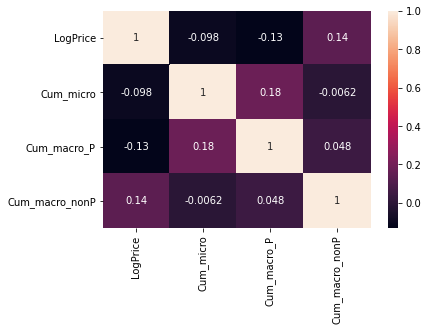

In [ ]:
#we first plot correlation matrix for all columnd in combineddata
import seaborn as sn
corrMatrix = combineddata[['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Observation: 

It can be seen that there are very week correlations among micro news (one day lagged), macro politic news(one day lagged) and returns. But one promising point is macro non-politic news(one day lagged) has always positive correlation between other variable. Probably we can built our trading strategy based on this factor. Lets run a cointegration test like the Augmented Dickey–Fuller test to see whether there is a sigfinicant correlation among those time series.

<AxesSubplot:xlabel='date'>

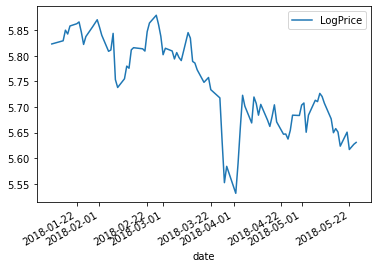

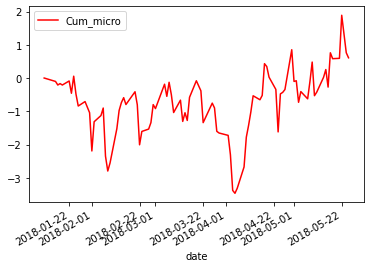

In [ ]:



combineddata.plot(y=['LogPrice'],use_index=True)
combineddata.plot(y=['Cum_micro'],use_index=True,color='red')

In [ ]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Do  Augmented Dickey–Fuller test for each series.
from statsmodels.tsa.stattools import adfuller
X = combineddata['LogPrice']
result = adfuller(X)
print('ADF results for LogPrice:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF results for LogPrice:
ADF Statistic: -1.496835
p-value: 0.535076
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


In [ ]:
from statsmodels.tsa.stattools import adfuller
X = combineddata['Cum_micro']
result = adfuller(X)
print('ADF results for Cum_micro:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF results for Cum_micro:
ADF Statistic: -2.836955
p-value: 0.053186
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


In [ ]:
from statsmodels.tsa.stattools import adfuller
X = combineddata['Cum_macro_P']
result = adfuller(X)
print('ADF results for Cum_macro_P:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF results for Cum_macro_P:
ADF Statistic: -4.799827
p-value: 0.000054
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


In [ ]:
from statsmodels.tsa.stattools import adfuller
X = combineddata['Cum_macro_nonP']
result = adfuller(X)
print('ADF results for Cum_macro_nonP:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF results for Cum_macro_nonP:
ADF Statistic: -8.907287
p-value: 0.000000
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


Do ADF test for log price series, and we found that this series is non stationary. This implies that we could do cointegration test next. Since cointegration test is used to check whether we could transform non-stationary series into stationary time series

In [ ]:
### consulted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

# Before even building the model. we use Granger’s Causality test to check the causality between every variables

# Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(combineddata[['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']], variables = combineddata[['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']].columns) 
#The row are the Response (Y) and the columns are the predictor series (X).

,LogPrice_x,Cum_micro_x,Cum_macro_P_x,Cum_macro_nonP_x
LogPrice_y,1.0000,0.4255,0.0315,0.0104
Cum_micro_y,0.0063,1.0000,0.3946,0.3742
Cum_macro_P_y,0.4018,0.7209,1.0000,0.0653
Cum_macro_nonP_y,0.2092,0.4394,0.1939,1.0000



Observation, from the matrix, we need to focus on the cells with value less than 0.05. For example,  P-Value of 0.0315 at (row 1, column 3) represents the p-value of the Grangers Causality test for Cum_macro_P_x causing LogPrice_y, which is less that the significance level of 0.05.

Therefore, from the matrix above, we can conclude that there exists some relationship between returns and Cum_macro_P_x and Cum_macro_nonP_x. Next, we perform cointegration test among those three variables.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(round(1-alpha,2))]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(combineddata[['LogPrice','Cum_macro_P','Cum_macro_nonP']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
LogPrice ::  26.36     > 24.2761   =>   True
Cum_macro_P ::  12.45     > 12.3212   =>   True
Cum_macro_nonP ::  0.96      > 4.1296    =>   False


Observation:
From the result of Johanson's Cointegration Test, we could conclude that there exists a cointegration relationship (95% confidence level) among log returns and Cum_macro_P. That is to say, we could build a stationary with those two variables and we can use the equation to predict one of them.

In [ ]:
#training, validation, testing
training_var=combineddata.iloc[0:72][['LogPrice','Cum_macro_P']]#,'Cum_macro_P','Cum_macro_nonP']]
#validation_var=combineddata.iloc[53:71][['Returns','Score(1)','Score(1)_macro_P']]
testing_var=combineddata.iloc[72:73][['LogPrice','Cum_macro_P']]#[['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']]

In [ ]:
#Initiate VAR model
from statsmodels.tsa.api import VAR


model = VAR(endog=training_var)
res = model.select_order(5)
res.summary()

/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-2.545,-2.479,0.07845,-2.519
1,-4.734*,-4.536*,0.008794*,-4.656*
2,-4.673,-4.343,0.009354,-4.542
3,-4.571,-4.110,0.01037,-4.389
4,-4.485,-3.893,0.01131,-4.251
5,-4.433,-3.709,0.01195,-4.146


In [ ]:
#Fit to a VAR model
model_fit = model.fit(maxlags=1)
#Print a summary of the model results
#model_fit.summary()

In [ ]:
# forecasting
lag_order=model_fit.k_ar
pred = model_fit.forecast(y=training_var.values[-lag_order:], steps=1)
pred = (pd.DataFrame(pred, index=testing_var.index, columns=testing_var.columns + '_pred'))
print(pred)

            LogPrice_pred  Cum_macro_P_pred
date                                       
2018-05-02       5.709422         -1.710935


In [ ]:
combineddata[['LogPrice','Cum_macro_P']].iloc[71:73]  ##actual value

,LogPrice,Cum_macro_P
date,,
2018-05-01,5.703516,0.397654
2018-05-02,5.707608,2.384827


It seems that if we choose time lag=1, our VAR model could predict the movement correctly after one trading days. (since predicted value is 5.709 which is larger than the current value(at 05-01, 5.703)Therefore, we will apply this idea in our back testing in Taks 7

# Task7
Backtest by utilizing results in 6. Show essential performance indicators. (e.g Sharp ratio,return rate).

Trading strategy:

1.   Using training data up to 2018-04-30(Since we would like to see the performance of our strategy in May), apply VAR model on that data.
2.   If predicted logprice is large than that of last day, we say the price of Tesla will move up, set as 1. And we buy the stock. If it is less than that of last day, set record as -1 and we sell the stock

3.   Once we observe the true movement, add new observation into our training data. 
4.   Repeat (1-3).


In [ ]:


record_VAR=[]
for i in range(19):
  #Include observed data into our training set
  updated_data=combineddata.iloc[0:(71+i)][['LogPrice','Cum_macro_P']]#,'Cum_macro_P','Cum_macro_nonP']]
  #testing_var=combineddata.iloc[(71+i)][['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']]

  model = VAR(endog=updated_data)
  model_fit = model.fit(maxlags=1)
  lag_order=model_fit.k_ar
  pred_new = model_fit.forecast(y=updated_data.values[-lag_order:], steps=1) #Extract predicted logprice
  #pred_new = (pd.DataFrame(pred_new, index=testing_var.index, columns=updated_data.columns + '_pred'))
  predicted_log=pred_new[0][0]
  if predicted_log>updated_data.iloc[70+i][0]: #>1.01:  #Compare with last day's price
    movement=1
  elif predicted_log <updated_data.iloc[70+i][0]: #<1/1.01:
    movement=-1
  else:
    movement=0
  record_VAR.append(movement)

record_VAR #list of trading signal

/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information a

[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
record_VAR  #List of signal

[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:

X=combineddata.iloc[70:][['LogPrice','Cum_macro_P']]

X['Signal']=np.array(record_VAR)  ##add signal to our dataframe

In [ ]:
X

,LogPrice,Cum_macro_P,Signal
date,,,
2018-04-30,5.683240,-0.482292,1
2018-05-01,5.703516,0.397654,1
2018-05-02,5.707608,2.384827,1
2018-05-03,5.650557,2.777514,1
2018-05-04,5.683886,2.546757,1
2018-05-07,5.712973,0.464078,1
2018-05-08,5.710328,-3.453861,1
2018-05-09,5.726359,0.125870,1
2018-05-10,5.720377,-5.186365,1


In [ ]:
#add 2018-5-30 data for completion of comparason
date=datetime(2018,5,30,0,0,0)

time_series_price_2018.loc[[date]]   #291.72  log(291.72)=5.67579

,Adj Close,LogPrice
date,,
2018-05-30,291.72,5.675794


In [ ]:
X2=X.append(pd.DataFrame([[5.67579,0,0]],columns=X.columns,index=time_series_price_2018.loc[[date]].index)) #Add the price on 2018-05-30

In [ ]:

#Backtest

initial_position=100
total_values=[initial_position*np.exp(X2['LogPrice'][0])]
total_value= initial_position*np.exp(X2['LogPrice'][0]) #initialization historical valuation 
profits=[]
for i in range((len(X2['Signal'])-1)):
  if X2['Signal'][i]==1:
    #buy
    long_pos=10
    short_pos=0
    total_pos=long_pos+short_pos
    total_value+=total_pos*(np.exp(X2['LogPrice'][i+1])-np.exp(X2['LogPrice'][i]))
    total_values.append(total_value)
    profit=total_values[i+1]/total_values[i]-1
    profits.append(profit)
  if X2['Signal'][i]==-1:
    #sell
    long_pos=0
    short_pos=-10
    total_pos=long_pos+short_pos
    total_value+=total_pos*(np.exp(X2['LogPrice'][i+1])-np.exp(X2['LogPrice'][i]))
    total_values.append(total_value)
    profit=total_values[i+1]/total_values[i]-1
    profits.append(profit)
  print("current valuation:",total_value)

profits,total_values,total_value

current valuation: 29450.199999999997
current valuation: 29462.499999999996
current valuation: 29295.499999999996
current valuation: 29391.899999999994
current valuation: 29478.699999999997
current valuation: 29470.699999999997
current valuation: 29519.499999999996
current valuation: 29501.199999999993
current valuation: 29461.599999999995
current valuation: 29552.499999999993
current valuation: 29630.39999999999
current valuation: 29607.39999999999
current valuation: 29587.99999999999
current valuation: 29510.79999999999
current valuation: 29587.499999999985
current valuation: 29492.699999999986
current valuation: 29521.099999999988
current valuation: 29531.099999999988
current valuation: 29659.78705315663


([0.0020483157536577146,
  0.00041765420947892373,
  -0.00566822231650399,
  0.0032906077725247673,
  0.0029531945876246635,
  -0.00027138238796142744,
  0.001655881943761095,
  -0.0006199291993429501,
  -0.001342318278578447,
  0.0030853721454366934,
  0.002635986803146917,
  -0.0007762298180247207,
  -0.0006552415950067392,
  -0.0026091658780587057,
  0.002599048483944655,
  -0.00320405576679339,
  0.0009629501537669061,
  0.00033874076507989237,
  0.004357678960710709],
 [29389.999999999996,
  29450.199999999997,
  29462.499999999996,
  29295.499999999996,
  29391.899999999994,
  29478.699999999997,
  29470.699999999997,
  29519.499999999996,
  29501.199999999993,
  29461.599999999995,
  29552.499999999993,
  29630.39999999999,
  29607.39999999999,
  29587.99999999999,
  29510.79999999999,
  29587.499999999985,
  29492.699999999986,
  29521.099999999988,
  29531.099999999988,
  29659.78705315663],
 29659.78705315663)

In [ ]:
X2['Daily_Return']=np.array(profits+[0])

In [ ]:
X2['Daily_Return']=X2['Daily_Return'].shift(1)

Maximum Drawdown during testing period(one month): -0.566822231650399 %


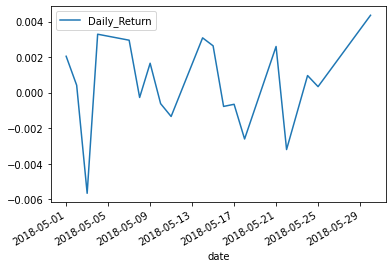

In [ ]:
X2.plot(y='Daily_Return',use_index=True)
#Plot of return rate
print('Maximum Drawdown during testing period(one month):',min(np.array(profits+[0]))*100,'%')

return rate after testing period(one month): 0.9179552676306102 %


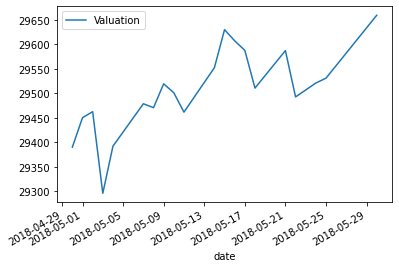

In [ ]:
X2['Valuation']=np.array(total_values)
#X2['Valuation']=X2['Valuation'].shift(1)
X2.plot(y='Valuation',use_index=True)
#Plot of valuation 
print('return rate after testing period(one month):',(X2['Valuation'][-1]/X2['Valuation'][0]-1)*100,'%')

# <font color=brown> Task 8: 

(Open end) Can we adjust some parameters or even methodology in task 6 to get better
results than in task 7?


The accuracy of the VADER sentiment analyser is kind of not perfect. It is based on lexicon and the performance may depend on the quality and type of data we are testing on. So one possible improvment might be trying a more comprenhensive dataset and precise algorithm.(Such as FinBert)

Of course, the accuracy of our classification also plays an important role in constructing features in our case. In this task, we will demonstrate how our backtest results will be affected by improving the accuracy of our classification results.

We will assume that our prediction is 100% correct. The corresponding result could be used a guidance to improve our classification methodology

In [ ]:
#Clustering
##Consulted https://towardsdatascience.com/how-nlp-has-evolved-for-financial-sentiment-analysis-fb2990d9b3ed


#analysis_tesla_df_2_t = analysis_tesla_df.groupby(['New Date']).sum()
news_df_test_politics_pd_2_t = news_df_test_politics_pd.groupby(['date','label'])['Score'].sum()
news_df_test_politics_pd_2_t=news_df_test_politics_pd_2_t.reset_index()


In [ ]:
#We divide data of news into two sub dataframes: politic news and non-politic news
#Non-politics
news_df_test_politics_pd_2_nonP_t=news_df_test_politics_pd_2_t[news_df_test_politics_pd_2_t['label']==0]
news_df_test_politics_pd_2_nonP_t=news_df_test_politics_pd_2_nonP_t.reset_index()

#Politics
news_df_test_politics_pd_2_P_t=news_df_test_politics_pd_2_t[news_df_test_politics_pd_2_t['label']==1]
news_df_test_politics_pd_2_P_t=news_df_test_politics_pd_2_P_t.reset_index()

In [ ]:
#convert string to datatime
news_df_test_politics_pd_2_P_t['date']=pd.to_datetime(news_df_test_politics_pd_2_P_t['date'])
news_df_test_politics_pd_2_nonP_t['date']=pd.to_datetime(news_df_test_politics_pd_2_nonP_t['date'])

In [ ]:
#Relabel the sentiment score for politics and non-politics

analysis_tesla_df_2['Score_micro'] = analysis_tesla_df_2['Score']#.shift(1)
news_df_test_politics_pd_2_nonP_t['Score_macro_nonP']=news_df_test_politics_pd_2_nonP_t['Score']#.shift(1)
news_df_test_politics_pd_2_P_t['Score_macro_P']=news_df_test_politics_pd_2_P_t['Score']#.shift(1)

In [ ]:
#analysis_tesla_df_2=analysis_tesla_df_2.rename_axis('date')
news_df_test_politics_pd_2_P_t=news_df_test_politics_pd_2_P_t.set_index('date')
news_df_test_politics_pd_2_nonP_t=news_df_test_politics_pd_2_nonP_t.set_index('date')



In [ ]:
# Use reduce method to merge corresponding data
dfs=[time_series_price_2018[['LogPrice']],analysis_tesla_df_2[['Score_micro']],news_df_test_politics_pd_2_P_t[['Score_macro_P']],
     news_df_test_politics_pd_2_nonP_t[['Score_macro_nonP']]]
combineddata_t = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              left_index=True, right_index=True, 
                                              how='inner'), 
                  dfs)

In [ ]:
combineddata_t['Cum_micro']=cumu_factor(combineddata_t['Score_micro'],0.8)
combineddata_t['Cum_macro_P']=cumu_factor(combineddata_t['Score_macro_P'],0.5)
combineddata_t['Cum_macro_nonP']=cumu_factor(combineddata_t['Score_macro_nonP'],0.1)

In [ ]:
record_VAR_t=[]
for i in range(19):
  #Include observed data into our training set
  updated_data=combineddata_t.iloc[0:(71+i)][['LogPrice','Cum_macro_P']]#,'Cum_macro_P','Cum_macro_nonP']]
  #testing_var=combineddata.iloc[(71+i)][['LogPrice','Cum_micro','Cum_macro_P','Cum_macro_nonP']]

  model = VAR(endog=updated_data)
  model_fit = model.fit(maxlags=1)
  lag_order=model_fit.k_ar
  pred_new = model_fit.forecast(y=updated_data.values[-lag_order:], steps=1) #Extract predicted logprice
  #pred_new = (pd.DataFrame(pred_new, index=testing_var.index, columns=updated_data.columns + '_pred'))
  predicted_log=pred_new[0][0]
  if predicted_log>updated_data.iloc[70+i][0]: #>1.01:  #Compare with last day's price
    movement=1
  elif predicted_log <updated_data.iloc[70+i][0]: #<1/1.01:
    movement=-1
  else:
    movement=0
  record_VAR_t.append(movement)

record_VAR_t #list of trading signal

/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/mmd/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information a

[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
record_VAR_t #list of trading signal



[1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
X_t=combineddata_t.iloc[70:][['LogPrice','Cum_macro_P']]

X_t['Signal']=np.array(record_VAR_t)  ##add signal to our dataframe

In [ ]:
#add 2018-5-30 data for completion of comparason
date=datetime(2018,5,30,0,0,0)

time_series_price_2018.loc[[date]]   #291.72 log(283.76)=5.67579

,Adj Close,LogPrice
date,,
2018-05-30,291.72,5.675794


In [ ]:
X2_t=X_t.append(pd.DataFrame([[5.67579,0,0]],columns=X_t.columns,index=time_series_price_2018.loc[[date]].index)) #Add the price on 2018-05-30

In [ ]:
#Backtest

initial_position=100
total_values=[initial_position*np.exp(X2_t['LogPrice'][0])]
total_value= initial_position*np.exp(X2_t['LogPrice'][0]) #initialization historical valuation 
profits=[]
for i in range((len(X2_t['Signal'])-1)):
  if X2_t['Signal'][i]==1:
    #buy
    long_pos=10
    short_pos=0
    total_pos=long_pos+short_pos
    total_value+=total_pos*(np.exp(X2_t['LogPrice'][i+1])-np.exp(X2_t['LogPrice'][i]))
    total_values.append(total_value)
    profit=total_values[i+1]/total_values[i]-1
    profits.append(profit)
  if X2_t['Signal'][i]==-1:
    #sell
    long_pos=0
    short_pos=-10
    total_pos=long_pos+short_pos
    total_value+=total_pos*(np.exp(X2_t['LogPrice'][i+1])-np.exp(X2_t['LogPrice'][i]))
    total_values.append(total_value)
    profit=total_values[i+1]/total_values[i]-1
    profits.append(profit)
  print("current valuation:",total_value)

current valuation: 29450.199999999997
current valuation: 29462.499999999996
current valuation: 29295.499999999996
current valuation: 29391.899999999994
current valuation: 29478.699999999997
current valuation: 29470.699999999997
current valuation: 29519.499999999996
current valuation: 29501.199999999993
current valuation: 29461.599999999995
current valuation: 29552.499999999993
current valuation: 29630.39999999999
current valuation: 29607.39999999999
current valuation: 29587.99999999999
current valuation: 29510.79999999999
current valuation: 29587.499999999985
current valuation: 29492.699999999986
current valuation: 29521.099999999988
current valuation: 29531.099999999988
current valuation: 29659.78705315663


In [ ]:
X2_t['Daily_Return']=np.array(profits+[0])
X2_t['Daily_Return']=X2_t['Daily_Return'].shift(1)

Maximum Drawdown during testing period(one month): -0.566822231650399 %


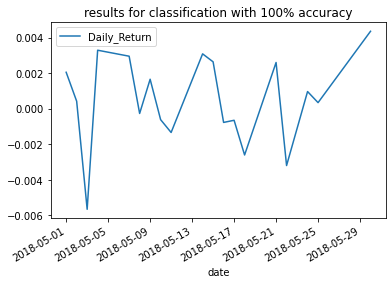

In [ ]:
X2_t.plot(y='Daily_Return',use_index=True,title='results for classification with 100% accuracy')
#Plot of return rate
print('Maximum Drawdown during testing period(one month):',min(np.array(profits+[0]))*100,'%')

return rate after testing period(one month): 0.9179552676306102 %


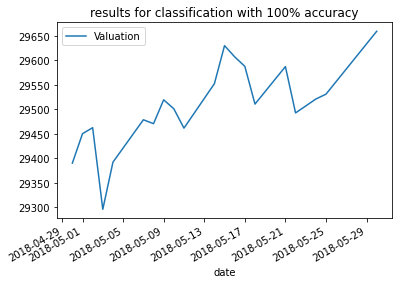

In [ ]:
X2_t['Valuation']=np.array(total_values)
#X2['Valuation']=X2['Valuation'].shift(1)
X2_t.plot(y='Valuation',use_index=True,title='results for classification with 100% accuracy')
#Plot of valuation 
print('return rate after testing period(one month):',(X2_t['Valuation'][-1]/X2_t['Valuation'][0]-1)*100,'%')

# Comments

We find that even if we use the true classification of politics news, the results didn't change(i.e our procedure gives us the same signal). That is to say, we have to tune our sentimental analysis to get better result. But as we said before, to get better results from sentimental analysis, probably we will apply deep neural network. This requires better GPU. So, we need financing!

# <font color=brown> Bonus task (Visiualization) (For the visiualization,please see the Jupyter notebook(Project3_task9_visualization of back test.ipynb): </font>


Also, the following code is just a reference.To get the same plot as we shown  in presentaiton, please check the Jupyter book "Project3_task9_visualization of back test.ipynb". Since there will be an issue of backtrader library with matplotlib(since on our server, the version is discomaptible with backtrader's inside version) when you plot the results.

I solved it by running my own notebook. So I will attach my own jupyter notebook in the project 3 folder.

For the safety of our server, probably I won't downgrade the version of matplotlib again on colab because the bug is the package itself . Because I have no access to the local path of the installed package (since you are the owner of the server) so I couldn't modify the source code of the package on our server.




# Observation:
Looking at the previous task, it seems that we only need Cum_Macro_Politics and log price to predict the stock movements. Therefore, we could have longer backtesting period.(we choose news from Huffpost from 2017-2018). Then we could give detailed outputs. Also, we will use the true label for politic news.(Since from task 8 we know the accuracy rate of classification might not improve backtest performance a lot.

In [ ]:
#Sentimental score for whole news data (2012-2018)
#news_df.groupby('category').count().sort(f.col('count').desc()).show() #whole data set we will utilize

# label each category
news_df_total=news_df.withColumn('category_id',f.when(f.col('category')=='ENTERTAINMENT',0)\
                                       .when(f.col('category')=='BUSINESS',1)\
                                       .when(f.col('category')=='SPORTS',2)\
                                       .when(f.col('category')=='POLITICS',3)\
                                       .otherwise(4))

In [ ]:
#total news data
news_df_total_politics=news_df_total.withColumn('label',f.when(f.col('category_id')==3,1).otherwise(0))

news_df_total_politics = news_df_total_politics.withColumn('Text', 
                    f.concat(f.col('headline'),f.lit(' '), f.col('short_description')))
news_df_total_politics=news_df_total_politics.select('label','date','Text')

In [ ]:
#choose news from 2017-2018
news_df_bonus_politics=news_df_total_politics.where(f.col('date')>'2016-12-31')

In [ ]:
news_df_total_politics_pd=news_df_bonus_politics.toPandas() #convert to pandas

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
#sentimental scores for total news data
results_test = []

for headline in news_df_total_politics_pd['Text']:
    pol_score = SIA().polarity_scores(headline) # run analysis
    pol_score['headline'] = headline # add headlines for viewing
    results_test.append(pol_score)

news_df_total_politics_pd['Score'] = pd.DataFrame(results_test)['compound']

In [ ]:
news_df_total_politics_pd_2 = news_df_total_politics_pd.groupby(['date','label'])['Score'].sum()
news_df_total_politics_pd_2=news_df_total_politics_pd_2.reset_index()

In [ ]:
#We divide data of news into two sub dataframes: politic news and non-politic news
#Non-politics
news_df_total_politics_pd_2_nonP=news_df_total_politics_pd_2[news_df_total_politics_pd_2['label']==0]
news_df_total_politics_pd_2_nonP=news_df_total_politics_pd_2_nonP.reset_index()

#Politics
news_df_total_politics_pd_2_P=news_df_total_politics_pd_2[news_df_total_politics_pd_2['label']==1]
news_df_total_politics_pd_2_P=news_df_total_politics_pd_2_P.reset_index()

In [ ]:
time_series_price['LogPrice'] = np.log(time_series_price['Adj Close'])
time_series_price_2017_2018=time_series_price[(time_series_price['Date']<datetime.strptime('2019-01-01', "%Y-%m-%d").date())
                                         &(time_series_price['Date']>datetime.strptime('2016-12-31', "%Y-%m-%d").date()) ]
time_series_price_2017_2018.head()     


,Date,Adj Close,LogPrice
1640,2017-01-03,216.99,5.379851
1641,2017-01-04,226.99,5.424906
1642,2017-01-05,226.75,5.423848
1643,2017-01-06,229.01,5.433766
1644,2017-01-09,231.28,5.443629


In [ ]:
news_df_total_politics_pd_2_nonP['Score_macro_nonP']=news_df_total_politics_pd_2_nonP['Score']#.shift(1)
news_df_total_politics_pd_2_P['Score_macro_P']=news_df_total_politics_pd_2_P['Score']#.shift(1)

In [ ]:
#convert string to datatime format
news_df_total_politics_pd_2_P['date']=pd.to_datetime(news_df_total_politics_pd_2_P['date'])
news_df_total_politics_pd_2_nonP['date']=pd.to_datetime(news_df_total_politics_pd_2_nonP['date'])

In [ ]:
#Set index by data for each dataframe
time_series_price_2017_2018=time_series_price_2017_2018.set_index('Date')
time_series_price_2017_2018=time_series_price_2017_2018.rename_axis('date')
news_df_total_politics_pd_2_P=news_df_total_politics_pd_2_P.set_index('date')
news_df_total_politics_pd_2_nonP=news_df_total_politics_pd_2_nonP.set_index('date')


In [ ]:
# Use reduce method to merge corresponding data

from functools import reduce
dfs=[time_series_price_2017_2018[['LogPrice']],time_series_price_2017_2018[['Adj Close']],news_df_total_politics_pd_2_P[['Score_macro_P']]]
combineddata_total = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                              left_index=True, right_index=True, 
                                              how='inner'), 
                  dfs)
combineddata_total.head(5)

In [ ]:
#define a function to calculate cumulative sentiment
def cumu_factor(data,decay_rate):
    out = np.zeros_like(data, dtype = float)
    #initial sentimental  score
    out[0] = data[0]
    for i in range(1, len(data)):
        #t+1 = t*(1+monthly) + deposit
        out[i] = out[i - 1]*decay_rate+ data[i]
    return out

In [ ]:
#get cumulative sentimental of market
combineddata_total['Cum_macro_P']=cumu_factor(combineddata_total['Score_macro_P'],0.6)  #change from 0.5 to 0.6 since we think politics might not be easy to forget

<AxesSubplot:xlabel='date'>

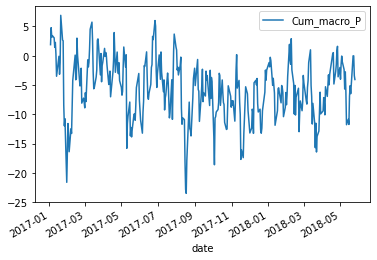

In [ ]:
combineddata_total.plot(y='Cum_macro_P',use_index=True)

In [ ]:
%pip install backtrader

Defaulting to user installation because normal site-packages is not writeable
  Using cached backtrader-1.9.76.123-py2.py3-none-any.whl (410 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
combineddata_total.index = pd.to_datetime(combineddata_total.index)

In [ ]:
combineddata_total.head(5)

In [ ]:
TSLA =combineddata_total[['Adj Close']]
PoliticSentiment=combineddata_total[['Cum_macro_P']]

In [ ]:
#define our strategy

##Note, this is not the same stratry we shown in the presentation. This strategy is based on BollingerBands, just a trial to play with this library.

##Format consulted from https://algotrading101.com/learn/backtrader-for-backtesting/
import backtrader as bt
class PSentiment(bt.Strategy):
	params = (('period', 21), ('devfactor', 2),)

	def log(self, txt, dt=None):
		dt = dt or self.datas[0].datetime.date(0)
		print(f'{dt.isoformat()} {txt}')

	def __init__(self):
		self.tsla_price = self.datas[0].close
		self.politic_sentiment = self.datas[1].close
		self.bbands = bt.indicators.BollingerBands(self.politic_sentiment, period=self.params.period, devfactor=self.params.devfactor)

		self.order = None

	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
			return

		if order.status in [order.Completed]:
			if order.isbuy():
				self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
			elif order.issell():
				self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Canceled/Margin/Rejected')

		self.order = None

	def next(self):
		# Check for open orders
		if self.order:
			return

		#Long signal 
		if self.politic_sentiment > self.bbands.lines.top[0]:
			# Check if we are in the market
			if not self.position:
				self.log(f'Politics Sentiment Value: {self.politic_sentiment[0]:.2f}')
				self.log(f'Top band: {self.bbands.lines.top[0]:.2f}')
				# We are not in the market, we will open a trade
				self.log(f'***BUY CREATE {self.tsla_price[0]:.2f}')
				# Keep track of the created order to avoid a 2nd order
				self.order = self.buy()       

		#Short signal
		elif self.politic_sentiment < self.bbands.lines.bot[0]:
			# Check if we are in the market
			if not self.position:
				self.log(f'Political Sentiment Value: {self.politic_sentiment[0]:.2f}')
				self.log(f'Bottom band: {self.bbands.lines.bot[0]:.2f}')
				# We are not in the market, we will open a trade
				self.log(f'***SELL CREATE {self.tsla_price[0]:.2f}')
				# Keep track of the created order to avoid a 2nd order
				self.order = self.sell()
		
		#Neutral signal - close any open trades     
		else:
			if self.position:
				# We are in the market, we will close the existing trade
				self.log(f'Political Sentiment Value: {self.politic_sentiment[0]:.2f}')
				self.log(f'Bottom band: {self.bbands.lines.bot[0]:.2f}')
				self.log(f'Top band: {self.bbands.lines.top[0]:.2f}')
				self.log(f'CLOSE CREATE {self.tsla_price[0]:.2f}')
				self.order = self.close()


In [ ]:
##Main logic for backtrader backtesting architecture

##Format consulted from https://algotrading101.com/learn/backtrader-for-backtesting/
import backtrader as bt

      
class TSLAPandasData(bt.feeds.PandasData):
    #lines = ('Adj Close','LogPrice')

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', 'Adj Close'),
        ('high', None),
        ('low', None),
        ('close', 'Adj Close'),
        ('volume', None),
        ('openinterest', None),
    )

class SentimentPandasData(bt.feeds.PandasData):
    #lines = ('Adj Close','LogPrice')

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', None),
        ('high', None),
        ('low', None),
        ('close', 'Cum_macro_P'),
        ('volume', None),
        ('openinterest', None),

    )


#Instantiate Cerebro engine
cerebro = bt.Cerebro()

#Add data feed to Cerebro
tsladata =TSLAPandasData(dataname=TSLA)
cerebro.adddata(tsladata)

politicdata =SentimentPandasData(dataname=PoliticSentiment)
cerebro.adddata(politicdata)

#Add strategy to Cerebro
cerebro.addstrategy(PSentiment)

# Add commission rate of 0.1% per trade
cerebro.broker.setcommission(commission=0.0025)

if __name__ == '__main__':

  start_portfolio_value = cerebro.broker.getvalue()
  #start backtest engine
  cerebro.run()
  cerebro.plot(volume=False,stdstats=False)
  end_portfolio_value = cerebro.broker.getvalue()
  pnl = end_portfolio_value - start_portfolio_value

  print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
  print(f'Final Portfolio Value: {end_portfolio_value:2f}')
  print(f'PnL: {pnl:.2f}')



# Comments

You can see the error above: "cannot import name 'warnings' from 'matplotlib.dates' (/usr/local/lib/python3.7/site-packages/matplotlib/dates.py)".

Actually, this is a bug I found in the backtrader pacakge :https://stackoverflow.com/questions/63471764/importerror-cannot-import-name-warnings-from-matplotlib-dates

Thus, to get an amazing plot, I will do the same procedure on my own Jupyter notebook.

In [ ]:
sc.stop()
ss.stop()